%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


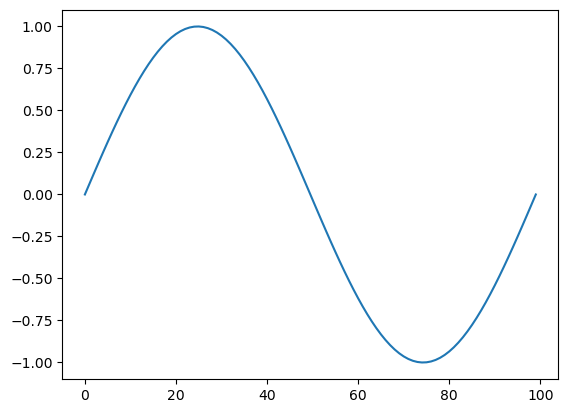

In [1]:
%pylab inline 
import matplotlib.pyplot as plt 
import numpy as np
plt.plot(np.sin(np.linspace(0,2*np.pi, 100)))

In [2]:
from timm.models.layers import DropPath, trunc_normal_
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from basic_tools import *
# 有时候下载数据集会报错，加下边这两行就可以了
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
def get_data_loaders(train_batch_size, test_batch_size, transform_train=None, transform_test=None):
    # 图像变换,预处理操作，
    if transform_train == None:
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    if transform_test == None:
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    train_data = torchvision.datasets.CIFAR100(
        root="../../data", train=True, download=False, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(
        train_data, batch_size=train_batch_size, shuffle=True, num_workers=0)
    test_data = torchvision.datasets.CIFAR100(
        root="../../data", train=False, download=False, transform=transform_test)
    testloader = torch.utils.data.DataLoader(
        test_data, batch_size=test_batch_size, shuffle=False, num_workers=0)

    return trainloader, testloader


In [4]:
batch_size = 128
trainloader, testloader = get_data_loaders(128, 128)

In [5]:
images, labels = next(iter(trainloader))
print(images.shape, labels.shape)

torch.Size([128, 3, 32, 32]) torch.Size([128])


In [6]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class WeightedPermuteMLP(nn.Module):
    def __init__(self, dim, segment_dim=8, proj_drop=0.):
        super().__init__()
        self.segment_dim = segment_dim

        self.mlp_c = nn.Linear(dim, dim)
        self.mlp_h = nn.Linear(dim, dim)
        self.mlp_w = nn.Linear(dim, dim)

        self.reweight = Mlp(dim, dim // 4, dim * 3)

        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, H, W, C = x.shape

        # print(x.shape)
        S = C // self.segment_dim
        h = x.reshape(B, H, W, self.segment_dim, S).permute(
            0, 3, 2, 1, 4).reshape(B, self.segment_dim, W, H*S)
        # print(h.shape)
        h = self.mlp_h(h).reshape(B, self.segment_dim, W, H, S).permute(
            0, 3, 2, 1, 4).reshape(B, H, W, C)

        w = x.reshape(B, H, W, self.segment_dim, S).permute(
            0, 1, 3, 2, 4).reshape(B, H, self.segment_dim, W*S)
        w = self.mlp_w(w).reshape(B, H, self.segment_dim, W, S).permute(
            0, 1, 3, 2, 4).reshape(B, H, W, C)

        c = self.mlp_c(x)

        a = (h + w + c).permute(0, 3, 1, 2).flatten(2).mean(2)
        a = self.reweight(a).reshape(B, C, 3).permute(
            2, 0, 1).softmax(dim=0).unsqueeze(2).unsqueeze(2)

        x = h * a[0] + w * a[1] + c * a[2]

        x = self.proj(x)
        x = self.proj_drop(x)

        return x


class PermutatorBlock(nn.Module):

    def __init__(self, dim, segment_dim, mlp_ratio=3.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm, skip_lam=1.0, mlp_fn=WeightedPermuteMLP):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = mlp_fn(dim, segment_dim=segment_dim)

        self.drop_path = nn.Identity()

        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim,
                       hidden_features=mlp_hidden_dim, act_layer=act_layer)
        self.skip_lam = skip_lam

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x))) / self.skip_lam
        x = x + self.drop_path(self.mlp(self.norm2(x))) / self.skip_lam
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=32, patch_size=16, in_chans=3, embed_dim=256):
        super().__init__()
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=(
            img_size // patch_size), stride=(img_size // patch_size))

    def forward(self, x):
        # print(x.shape)
        x = self.proj(x)  # B, C, H, W
        return x

def basic_blocks(dim, index, layers, segment_dim, mlp_ratio=3.,
                 skip_lam=1.0, mlp_fn=WeightedPermuteMLP, **kwargs):
    blocks = []

    for block_idx in range(layers[index]):
        blocks.append(PermutatorBlock(dim, segment_dim, mlp_ratio=mlp_ratio,
                                      skip_lam=skip_lam, mlp_fn=mlp_fn))

    blocks = nn.Sequential(*blocks)

    return blocks


class VisionPermutator(nn.Module):
    """ Vision Permutator
    """

    def __init__(self, layers, img_size=32, patch_size=32, in_chans=3, num_classes=100,
                 embed_dims=None, segment_dim=None,
                 norm_layer=nn.LayerNorm, mlp_fn=WeightedPermuteMLP):

        super().__init__()
        self.num_classes = num_classes

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dims[0])

        network = []
        for i in range(len(layers)):
            stage = basic_blocks(embed_dims[i], i, layers, segment_dim[i],
                                 norm_layer=norm_layer,
                                 mlp_fn=mlp_fn)
            network.append(stage)

        self.network = nn.ModuleList(network)

        self.norm = norm_layer(embed_dims[-1])

        # Classifier head
        self.head = nn.Linear(embed_dims[-1], num_classes)
        self.apply(self._init_weights)

    def forward_embeddings(self, x):
        x = self.patch_embed(x)
        # B,C,H,W-> B,H,W,C
        x = x.permute(0, 2, 3, 1)
        return x

    def forward_tokens(self, x):
        for idx, block in enumerate(self.network):
            x = block(x)
        B, H, W, C = x.shape
        x = x.reshape(B, -1, C)
        return x

    def forward(self, x):
        x = self.forward_embeddings(x)
        # B, H, W, C -> B, N, C
        x = self.forward_tokens(x)
        x = self.norm(x)
        return self.head(x.mean(1))

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)


In [7]:
layers = [4, 3, 8, 3]
segment_dim = [8, 8, 8, 8]
embed_dims = [128, 128, 128, 128]
net = VisionPermutator(layers, embed_dims=embed_dims, patch_size=8,
                       segment_dim=segment_dim, mlp_fn=WeightedPermuteMLP)
image, label = next(iter(trainloader))
net(image)
# print(net)

tensor([[ 5.5242e-02,  5.5209e-02,  2.1223e-02,  ..., -3.0649e-02,
         -7.8376e-03, -2.4553e-02],
        [ 1.7474e-01, -5.1498e-02,  1.3976e-04,  ..., -1.3612e-01,
         -7.9858e-02, -2.4541e-02],
        [ 1.5474e-01,  7.1648e-02,  1.0867e-01,  ..., -5.6052e-02,
         -1.3599e-02, -1.2007e-02],
        ...,
        [ 1.4627e-02,  1.1489e-01,  1.5512e-01,  ...,  8.3261e-03,
          1.0699e-01, -5.1170e-02],
        [ 8.8783e-02,  7.7250e-03, -2.6978e-02,  ...,  9.6237e-03,
         -7.0544e-02, -1.3782e-01],
        [ 1.2792e-01, -4.6286e-02, -1.5088e-02,  ...,  5.1456e-02,
         -9.0957e-02, -4.0460e-02]], grad_fn=<AddmmBackward0>)

In [8]:
from thop import profile
input = torch.randn(1, 3, 32, 32)
Flops, params = profile(net, inputs=(input,)) # macs
print(Flops, params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
190657024.0 3298596.0


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
learning_rate = 0.05
momentum = 0.9
weight_decay = 0.0001
epochs = 200
model = VisionPermutator(layers, embed_dims=embed_dims, patch_size=8,
                         segment_dim=segment_dim, mlp_fn=WeightedPermuteMLP).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optimizer = optim.SGD(model.parameters(
), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)


cuda


epoch:0,train_loss:4.0610,train_acc:7.2620,train_top5_acc:24.5200,test_loss:3.8046,test_acc:10.8400,test_top5_acc:32.6600
epoch:1,train_loss:3.6943,train_acc:12.5800,train_top5_acc:36.0960,test_loss:3.5850,test_acc:14.3600,test_top5_acc:40.2100
epoch:2,train_loss:3.4543,train_acc:16.7520,train_top5_acc:43.2380,test_loss:3.3118,test_acc:19.8600,test_top5_acc:47.9200


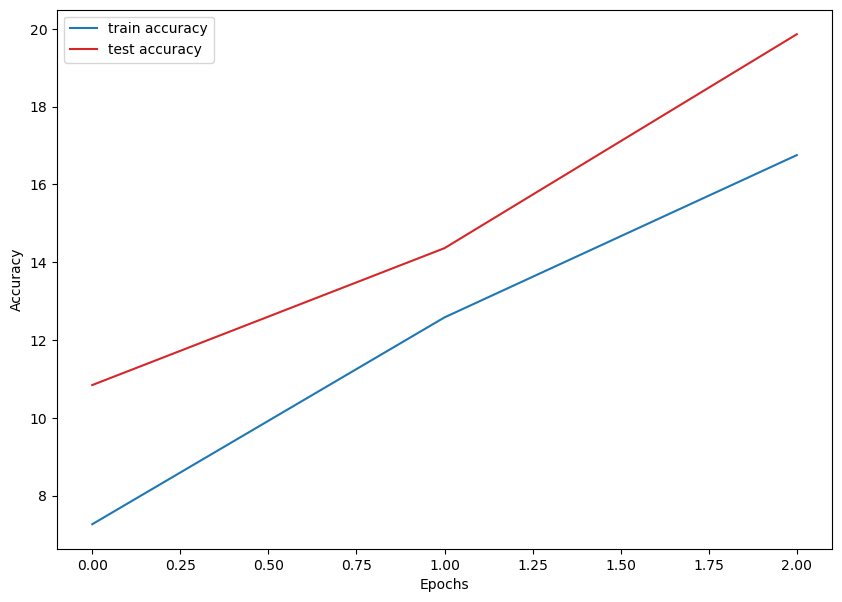

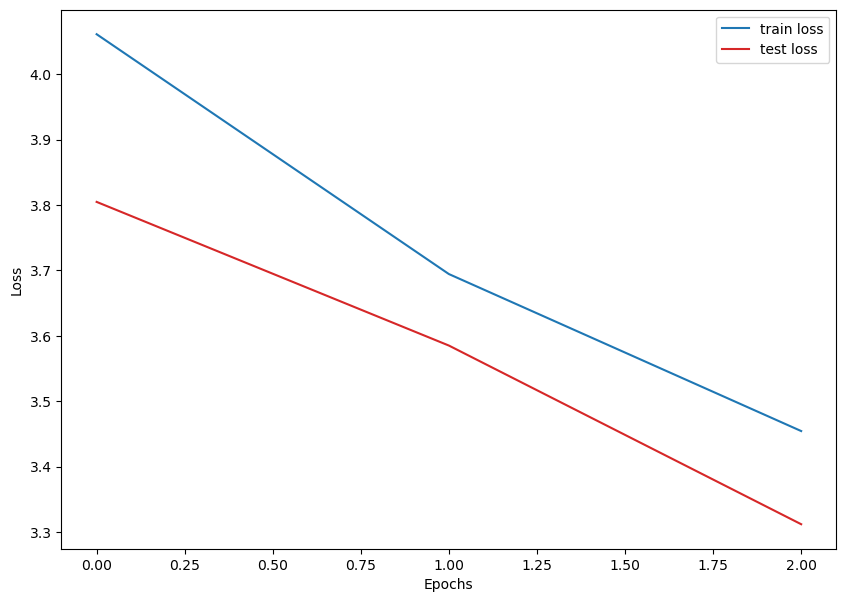

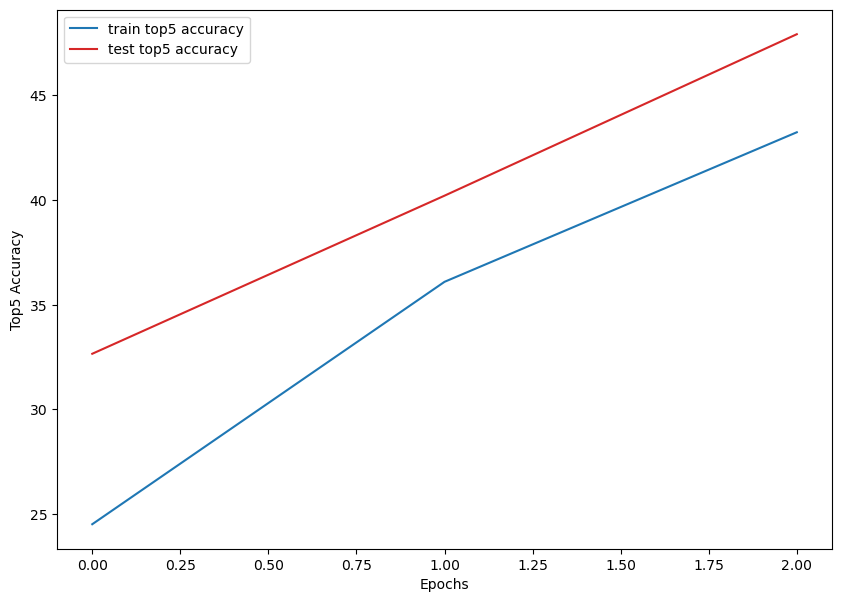

In [10]:
# 训练之
train_lossa, test_lossa = [], []
train_acca, test_acca = [], []
train_top5_acca, test_top5_acca = [], []
for epoch in range(epochs):
    train_loss, train_acc, train_top5_acc = train(
        model, trainloader, criterion, optimizer, device)
    test_loss, test_acc, test_top5_acc = test(
        model, testloader, criterion, device)
    print('epoch:{},train_loss:{:.4f},train_acc:{:.4f},train_top5_acc:{:.4f},test_loss:{:.4f},test_acc:{:.4f},test_top5_acc:{:.4f}'.format(
        epoch, train_loss, train_acc, train_top5_acc, test_loss, test_acc, test_top5_acc))
    train_lossa.append(train_loss)
    test_lossa.append(test_loss)
    train_acca.append(train_acc)
    test_acca.append(test_acc)
    train_top5_acca.append(train_top5_acc)
    test_top5_acca.append(test_top5_acc)

save_plots(train_acca, test_acca, train_lossa, test_lossa, train_top5_acca, test_top5_acca, "vip_epoch=150")